In [1]:
"""intent: to make the simplest model and submit to kaggle to have a baseline to start
todo: transfer learning from resnet, 
- scramble final layer
- redo classifer"""


'intent: to make the simplest model and submit to kaggle to have a baseline to start\ntodo: transfer learning from resnet, \n- scramble final layer\n- redo classifer'

setup tasts
rename data/train/train (where the images are)
to data/train/images

In [2]:
from fastai.vision.all import *

/home/highorder/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
import pandas as pd

train_dir = 'data/train/images'
path = Path('data/train/images')
image_files = os.listdir(train_dir)
df = pd.DataFrame({'filename': image_files})
df['id'] = df['filename'].str.split('.').str[0]
print(df.head())

                     filename      id
0  660315.jpg:Zone.Identifier  660315
1                  135654.jpg  135654
2  150810.jpg:Zone.Identifier  150810
3  804916.jpg:Zone.Identifier  804916
4                  759913.jpg  759913


Random row data:
id                  710114
shapeset                 1
type                     1
total_height             4
instability_type         1
cam_angle                2
stable_height            1
Name: 5385, dtype: int64


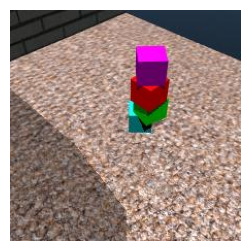

In [4]:
import pandas as pd
import random
from PIL import Image
import os
import matplotlib.pyplot as plt

# Load the data
train_data = pd.read_csv('data/train/train.csv')



# # Pick a random row
random_row = train_data.sample(n=1).iloc[0]

# Print the data for the random row
print("Random row data:")
print(random_row)

# Display the relevant image
image_path = os.path.join('data', 'train', 'images', f"{random_row['id']}.jpg")
try:
    img = Image.open(image_path)
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Image not found: {image_path}")

In [5]:
files = get_image_files(train_dir)
len(files)

7680

In [6]:
#ignoring extra info just label
# Assuming you've already loaded your CSV into a DataFrame called 'train_data'
id_to_label = dict(zip(train_data['id'], train_data['stable_height']))

In [7]:


from pathlib import Path

def label_func(file_path):
    if isinstance(file_path, str):
        file_path = Path(file_path)
    file_name = file_path.name
    image_id = file_name.split('.')[0]  # Assumes filenames are like "id.jpg"
    return id_to_label[int(image_id)]

# Test the function
print(label_func(files[0]))

5


In [8]:
path = Path('data/train')

In [9]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=[Resize(224),RandomResizedCrop(224)])

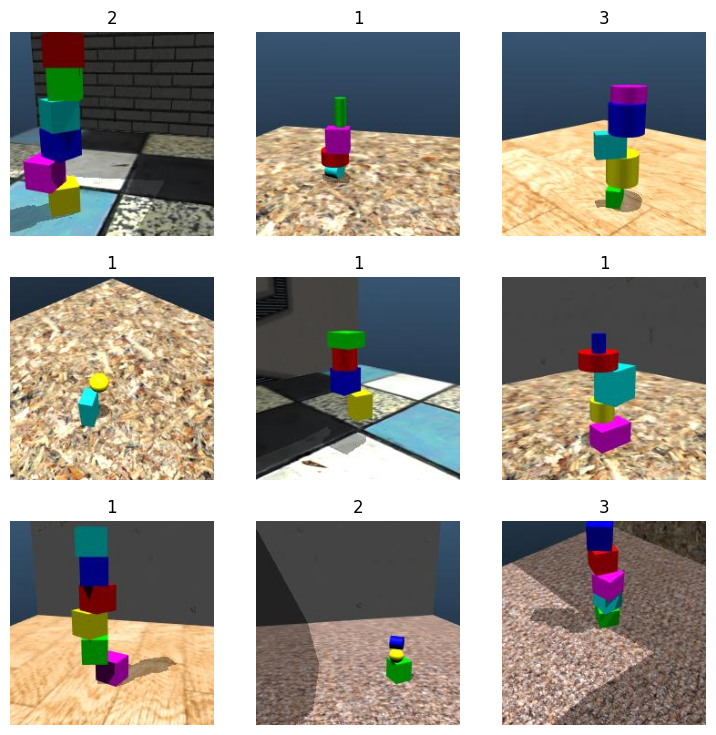

In [10]:
dls.show_batch()

In [17]:
learn = vision_learner(dls, 'inception_v4', metrics=[accuracy], cbs=CSVLogger())

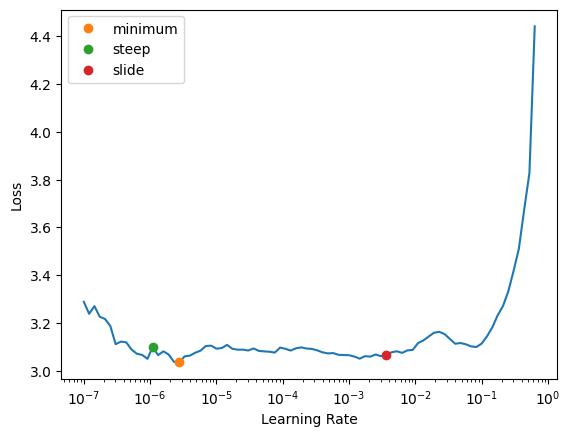

In [20]:
# Find the learning rate
lr_learn = learn.lr_find(suggest_funcs=(minimum, steep,slide))

In [21]:
lr_min, lr_steep, lr_slide = lr_learn

In [22]:
learn.fine_tune(6,lr_slide)

epoch,train_loss,valid_loss,accuracy,time
0,2.686938,1.999729,0.251953,00:58


epoch,train_loss,valid_loss,accuracy,time
0,1.742167,1.753652,0.271484,01:31
1,1.590994,1.730894,0.273438,01:31
2,1.303228,1.866153,0.277344,01:26
3,0.897877,2.042437,0.281901,01:11
4,0.535361,2.156092,0.281250,01:29
5,0.371308,2.182471,0.286458,01:14


In [23]:
learn.fine_tune(10,lr_slide)

epoch,train_loss,valid_loss,accuracy,time
0,0.486354,3.011703,0.279948,00:56


epoch,train_loss,valid_loss,accuracy,time
0,0.445374,2.779713,0.286458,01:20
1,0.340234,3.006274,0.286458,01:14
2,0.337748,3.379260,0.276693,01:14


KeyboardInterrupt: 

In [24]:
learn.freeze_to(-2) 
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2)) 

epoch,train_loss,valid_loss,accuracy,time
0,1.793637,1.666622,0.298177,01:15


In [26]:
learn.freeze_to(-3) 
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time


In [27]:
learn.unfreeze() 
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3)) 

epoch,train_loss,valid_loss,accuracy,time
0,1.074264,1.597280,0.359375,01:20
1,0.749966,1.674398,0.348307,01:15


In [19]:


# Get the suggested learning rate
suggested_lr = learn.recorder.suggest()

# Use the minimum of the suggested learning rate and a steep value (1e-3)
lr = min(suggested_lr, 1e-3)

print(f"Using learning rate: {lr}")

# Fine-tune the model with the chosen learning rate
learn.fine_tune(2, lr)


AttributeError: 'Sequential' object has no attribute 'suggest'

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [12]:
import timm

timm.list_models('*inception*')

['inception_next_base',
 'inception_next_small',
 'inception_next_tiny',
 'inception_resnet_v2',
 'inception_v3',
 'inception_v4']

In [13]:
# Get the final accuracy and epoch values
final_accuracy = df['accuracy'].iloc[-1]
final_epoch = df['epoch'].iloc[-1]

# Calculate the sum of the time column
total_time = pd.to_timedelta(df['time'].apply(lambda x: f'00:{x}')).sum()

print(f"acc{final_accuracy:.3f}_epo{final_epoch:02d}_tim{total_time.total_seconds():.0f}s")


KeyError: 'accuracy'

In [ ]:
df = learn.csv_logger.read_log()
test_eq(df.columns.values, learn.recorder.metric_names)
for i,v in enumerate(learn.recorder.values):
    test_close(df.iloc[i][:3], [i] + v)
os.remove(learn.path/learn.csv_logger.fname)

ValueError: operands could not be broadcast together with shapes (3,) (4,) 

## Results Exploration <a name="results-exploration"></a>

<details>
<summary>Click to expand</summary>

</details>


Error rate: 0.704427 means the model's wrong about 70% of the time. For a 6-class problem, that's barely better than random guessing (which would be wrong 83% of the time).

Valid loss: 1.724968 is pretty high. Lower is better, and for a well-performing model, you'd want to see this below 1.

In [ ]:
learn.predict(files[0])

('5', tensor(4), tensor([0.0467, 0.0642, 0.3041, 0.1876, 0.3251, 0.0723]))

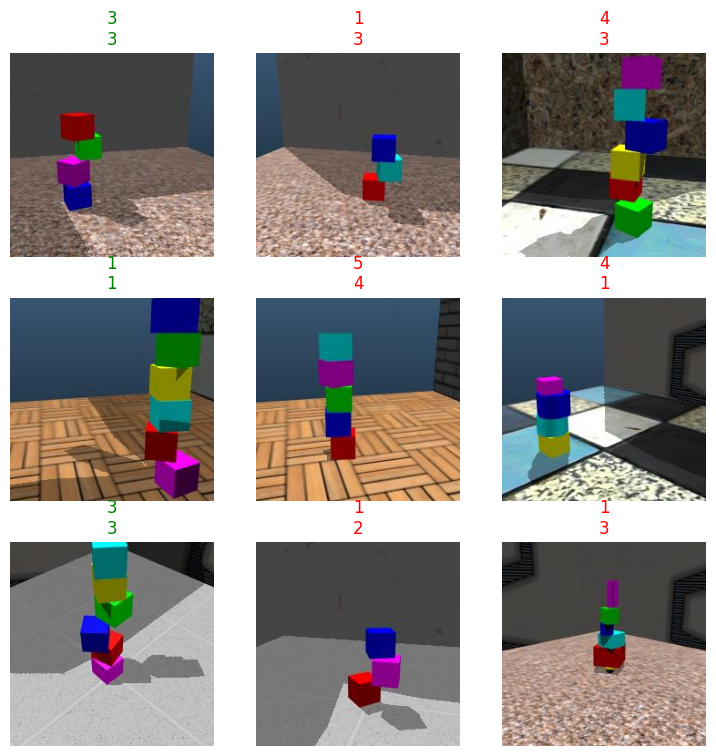

In [ ]:
learn.show_results()

1. load the data


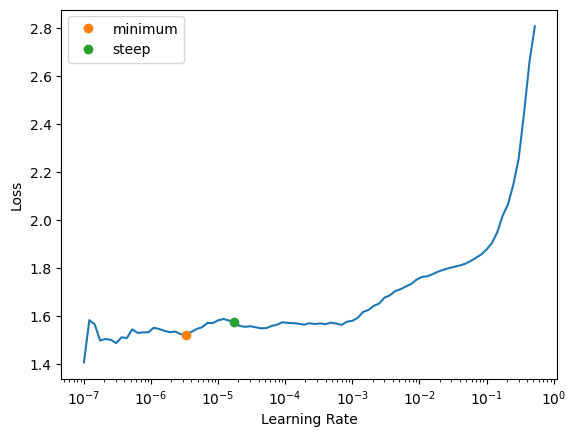

In [ ]:
from fastai.learner import Learner
from typing import Tuple

def find_optimal_lr(learner: Learner) -> float:
    lr_learn: Tuple[float, float] = learner.lr_find(suggest_funcs=(minimum, steep))
    lr_min, lr_steep = lr_learn
    optimal: float = lr_steep / 5
    return optimal

def get_final_accuracy(learner):
    """
    I theoretically could store it in a callback after each epoch, but would take 20min + to code
    """
    return learner.recorder.metrics[0].value.item()

## continuing finetuning <a name="results-exploration"></a>

In [ ]:
suggested_lr = learn.recorder.min_grad_lr
print(suggested_lr)


AttributeError: 'Sequential' object has no attribute 'min_grad_lr'

SuggestedLRs(valley=6.30957365501672e-05)

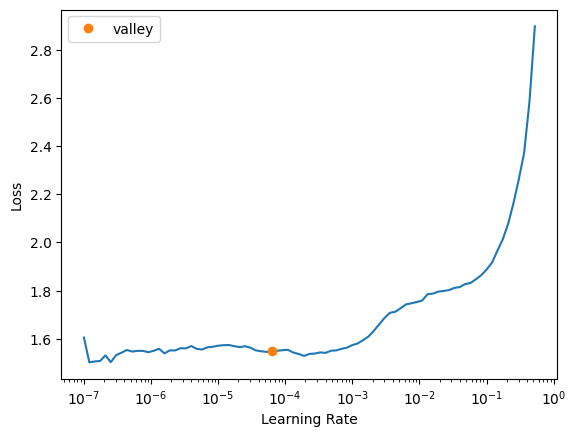

In [ ]:
learn.lr_find()

In [ ]:
# Let's check the help for learn.fine_tune
help(learn.fine_tune)


Help on method fine_tune in module fastai.callback.schedule:

fine_tune(epochs, base_lr=0.002, freeze_epochs=1, lr_mult=100, pct_start=0.3, div=5.0, *, lr_max=None, div_final=100000.0, wd=None, moms=None, cbs=None, reset_opt=False, start_epoch=0) method of fastai.learner.Learner instance
    Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR.



In [ ]:
# After training is complete

# Get the recorded values
records = learn.recorder.values

# Create a DataFrame
results_df = pd.DataFrame(records)

# The column names might need adjustment
results_df.columns = ['epoch', 'train_loss', 'valid_loss', 'rmse', 'time']

# Save to JSON
results_df.to_json('training_results.json', orient='records')

print("Training results saved to training_results.json")
print(results_df)  # Display the DataFrame to verify the contents

learn.fine_tune(2, 4e-4)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 5 elements

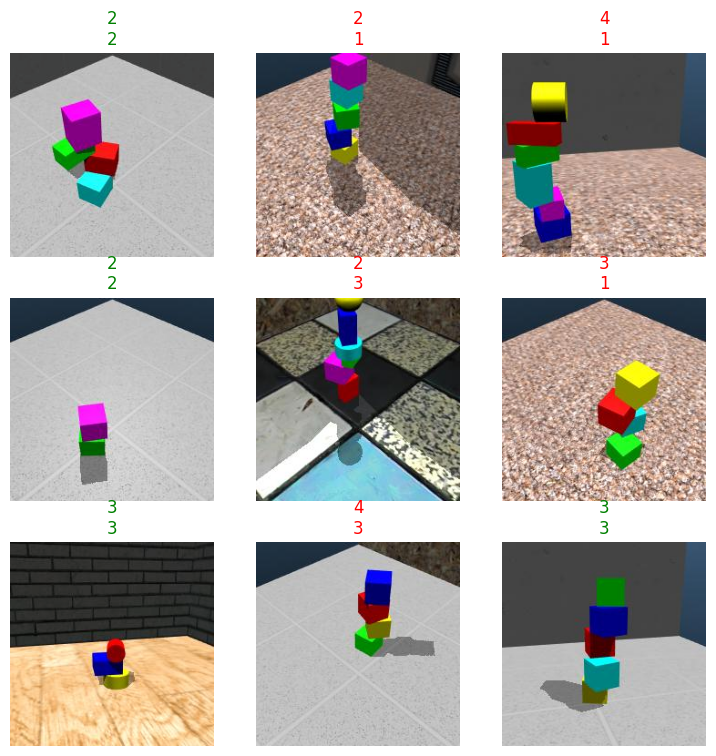

In [ ]:
learn.show_results()

In [ ]:
interp = Interpretation.from_learner(learn)

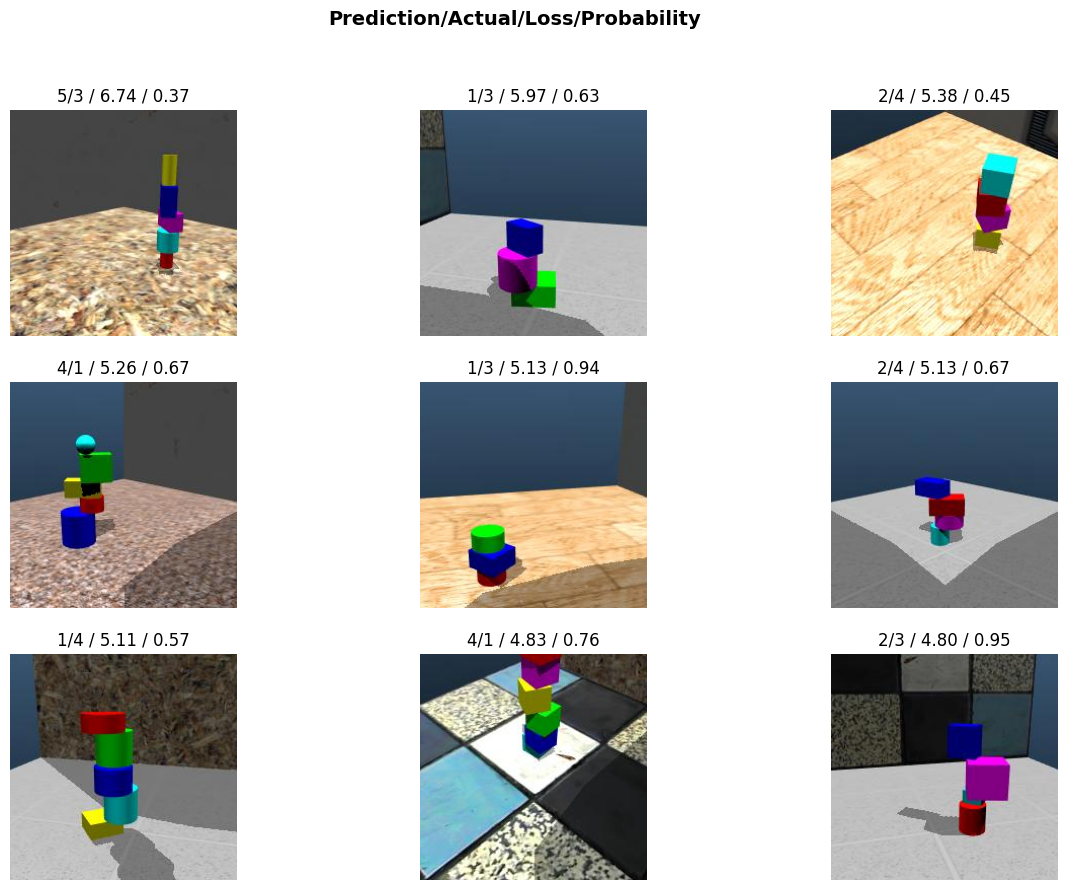

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))